In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from math import sqrt
import numpy as np
from bisect import bisect_left

In [3]:
# oracle price
p_o = 1700

# collateral grid settings
p_base = 1850
A = 100
N = 10


In [4]:
def p_up(n):
    return ((A-1)/A)**n * p_base

def p_down(n):
    return ((A-1)/A)**(n+1) * p_base

p_up(4), p_up(5)

(1777.1026184999998, 1759.3315923149999)

In [5]:
# p_o * A * y_0**2 - y_0 (p_up * (A - 1) * x / p_o + p_o**2 * A * y / p_up) - x * y = 0

def calc_y_0(p_o, n, x, y):
    a = p_o * A
    b = - (p_up(n) * (A-1) * x / p_o + p_o**2 * A * y / p_up(n))
    c = - x * y

    return (-b + sqrt(b**2 - 4*a*c) ) / (2*a)

calc_y_0(p_o, 0, 1000, 10)

9.828910958786647

In [6]:
def amm_band(p_o, n, x, y):
    p_cd = p_o**3 / p_up(n)**2
    p_cu = p_o**3 / p_down(n)**2
    y_0 = calc_y_0(p_o, n, x, y)
    f = p_o**2 / p_up(n) * A * y_0
    g = p_up(n) * (A-1) / p_o * y_0
    I = p_o * A**2 * y_0**2
    return {
        "p_cd": p_cd,
        "p_cu": p_cu,
        "p": (x + f) / (g + y),
        "y_0": y_0,
        "f": f,
        "g": g,
        "I": I
    }

amm_band(p_o, n=3, x=1200, y = 1)

{'p_cd': 1524.7271715111642,
 'p_cu': 1555.6853091635185,
 'p': 1538.2130301398336,
 'y_0': 1.6891234340636727,
 'f': 271945.52564886527,
 'g': 176.573275155545,
 'I': 48503345.58355193}

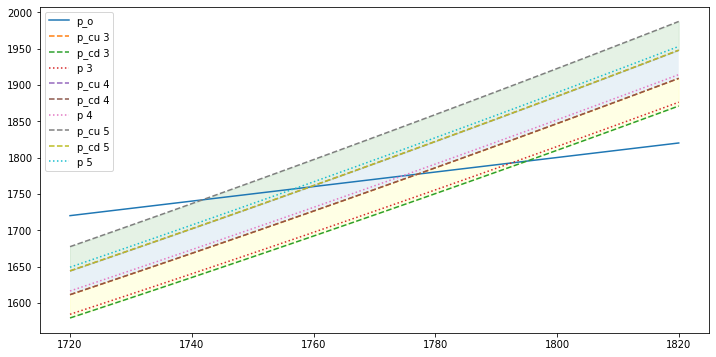

In [7]:
f, ax = plt.subplots(figsize=(12,6))


x = 2400  # stable
y = 8  # collateral

prices = np.linspace(1720, 1820, 100)

ax.plot(prices, prices, label="p_o")


n = 3
amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]  # same as p_cu for n-1
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

ax.plot(prices, amm_up_prices, '--', label="p_cu 3")
ax.plot(prices, amm_down_prices, '--', label="p_cd 3")
ax.plot(prices, amm_center_prices, ':', label="p 3")
ax.fill_between(prices, amm_down_prices, amm_up_prices, color='yellow', alpha=0.1)

n = 4
amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

ax.plot(prices, amm_up_prices, '--', label="p_cu 4")
ax.plot(prices, amm_down_prices, '--', label="p_cd 4")
ax.plot(prices, amm_center_prices, ':', label="p 4")
ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

n = 5
amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]  # same as p_cu for n-1
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

ax.plot(prices, amm_up_prices, '--', label="p_cu 5")
ax.plot(prices, amm_down_prices, '--', label="p_cd 5")
ax.plot(prices, amm_center_prices, ':', label="p 5")
ax.fill_between(prices, amm_down_prices, amm_up_prices, color='green', alpha=0.1)


ax.legend()

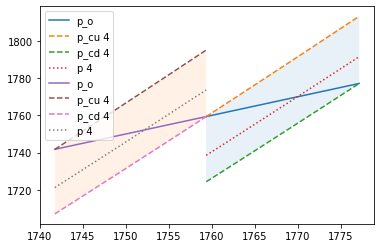

In [8]:
f, ax = plt.subplots()


x = 1200  # stable
y = 1  # collateral

n = 4
prices = np.linspace(p_down(n), p_up(n), 100)


ax.plot(prices, prices, label="p_o")

amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

ax.plot(prices, amm_up_prices, '--', label="p_cu 4")
ax.plot(prices, amm_down_prices, '--', label="p_cd 4")
ax.plot(prices, amm_center_prices, ':', label="p 4")
ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

n = 5
prices = np.linspace(p_down(n), p_up(n), 100)


ax.plot(prices, prices, label="p_o")

amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

ax.plot(prices, amm_up_prices, '--', label="p_cu 4")
ax.plot(prices, amm_down_prices, '--', label="p_cd 4")
ax.plot(prices, amm_center_prices, ':', label="p 4")
ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)



ax.legend()

## Setting the collateral bands for collateral and debt amounts


Average swap price (adiabatic trading in band `n`:

`sqrt(p_up(n) * p_down(n)) == p_up(n) * sqrt((A-1)/A)`


Handy formula for calculating "effective" liquidation amount (result from soft liquidation):

```
x_effective = (y/N) * [ p_up(n) * sqrt(A-1)/A + (A-1)/A * p_up(n) * sqrt(A-1)/A 
    + ((A-1)/A)**2 * p_up(n) * sqrt(A-1)/A + ... + ((A-1)/A)**(N-1) * p_up(n) * sqrt(A-1)/A ]
    = (y/N) * sqrt((A-1)/A) * p_up(n) * [ 1 + ((A-1)/A) + ((A-1)/A)**2 + ... + ((A-1)/A)**(N-1) ]
    = y_effective * p_up(n)
```

As `n` increases, `y_effective * p_up(n)` will decrease.  When creating a loan, we calculate the maximal `n` such that  `y_effective * p_up(n)` is still more than the desired debt amount.  This is how the collateral range is determined.

## Comparing soft liquidation to hard liquidation

In [9]:
def p_current_mid(p_o, n):
    return p_o**3 / (p_down(n) * p_up(n))

def get_x_down(p_o):
    """
    Calculate amount gained from arbs swapping through all AMM bands priced below p_o
    assuming p_o is dropping so that each band has only collateral to start with
    """
    x_equiv = 0
    for n in range(N):
        if p_o < p_down(n): # need to sell all the collateral
            x_equiv += (y/N) * p_current_mid(p_o, n)
        elif p_o > p_up(n): # we assume bands only have collateral so no need to buy
            continue
        else: # p_o is within the band
            # calculate quantities after trading to p_o: x_o, y_o
            # p_o = (f + x_o) / (g + y_o) 
            # p_o * (g + y_o)**2 = I or (f + x_o)**2 / p_o = I
            band = amm_band(p_o, n, x=0, y=y/N)
            f = band["f"]
            g = band["g"]
            I = band["I"]
            x_o = sqrt(I * p_o) - f
            y_o = sqrt(I / p_o) - g
            x_equiv += x_o
            x_equiv += sqrt(p_o * p_down(n)) * y_o  # start swap of y_o at price p_down, ending at p_o
    return x_equiv

get_x_down(p_o)

1415.2834680064461

Value at start of liquidation: 46250.0
Hard vs soft liquidation loss: 0.02219851742120227
Hard vs soft liquidation loss: 71.00866946763199
Hard vs soft liquidation loss: 272.4258763137004
Hard vs soft liquidation loss: 610.8199749170344
Hard vs soft liquidation loss: 1061.6172527631024
Hard vs soft liquidation loss: 1634.1352476713728
Hard vs soft liquidation loss: 2327.1597589581143
Hard vs soft liquidation loss: 3122.0732947144643
Hard vs soft liquidation loss: 4030.4124812816954
Hard vs soft liquidation loss: 5029.094835740732


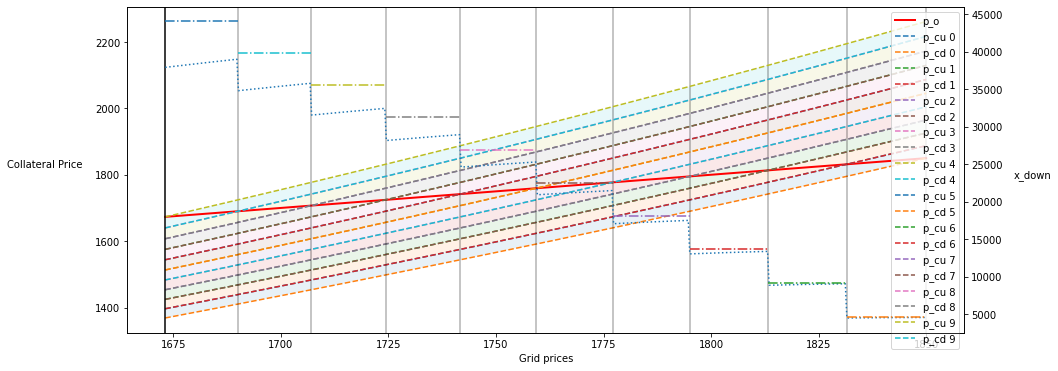

In [10]:
f, ax = plt.subplots(figsize=(15,6))
ax.set_ylabel("Collateral Price", rotation=0, labelpad=50)
ax.set_xlabel("Grid prices")
ax2 = ax.twinx()
ax2.set_ylabel("x_down", rotation=0, labelpad=30)


x = 0  # stable
y = 25  # collateral

print("Value at start of liquidation:", y * p_up(0))

prices = np.linspace(p_up(N), p_up(0), 500)

ax.plot(prices, prices, label="p_o", linewidth=2, color='r')

x_downs = [get_x_down(p) for p in prices]
ax2.plot(prices, x_downs, ':', label="x_down")

x_effective = 0

for n in range(N):
    ax.axvline(p_up(n), color='black', alpha=0.3)
    amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
    amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]  # same as p_cu for n-1
    amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

    ax.plot(prices, amm_up_prices, '--', label=f"p_cu {n}")
    ax.plot(prices, amm_down_prices, '--', label=f"p_cd {n}")
    # ax.plot(prices, amm_center_prices, ':', label=f"p {n}")
    ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)
    
    # x += y/N * sqrt(p_up(n) * p_down(n))
    x_effective += y/N * p_up(n) * sqrt((A-1)/A)
    ax2.plot(np.linspace(p_down(n), p_up(n), 25), [x_effective]* 25, '-.')
    
    i = bisect_left(list(prices), p_up(n))
    print("Hard vs soft liquidation loss:", x_effective - x_downs[i-1])
    
ax.axvline(p_up(N), color='black')

ax.legend()